<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/example%20Fuzzy%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

additional info:
https://zenodo.org/records/3841923

In [1]:
# Fuzzy Neural Network Implementation for Google Colab
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:


# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class FuzzyLayer(nn.Module):
    """
    Fuzzy Layer implementation using Gaussian membership functions
    """
    def __init__(self, input_dim, num_memberships):
        super(FuzzyLayer, self).__init__()
        self.input_dim = input_dim
        self.num_memberships = num_memberships

        # Initialize centers and sigmas for Gaussian membership functions
        self.centers = nn.Parameter(torch.randn(num_memberships, input_dim))
        self.sigmas = nn.Parameter(torch.ones(num_memberships, input_dim))

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        # centers shape: (num_memberships, input_dim)
        # sigmas shape: (num_memberships, input_dim)

        # Expand dimensions for broadcasting
        x_expanded = x.unsqueeze(1)  # (batch_size, 1, input_dim)
        centers_expanded = self.centers.unsqueeze(0)  # (1, num_memberships, input_dim)
        sigmas_expanded = self.sigmas.unsqueeze(0)  # (1, num_memberships, input_dim)

        # Calculate Gaussian membership function
        # μ(x) = exp(-0.5 * ((x - center) / sigma)^2)
        diff = x_expanded - centers_expanded
        normalized_diff = diff / sigmas_expanded
        membership_values = torch.exp(-0.5 * normalized_diff ** 2)

        # Combine memberships across features (product t-norm)
        fuzzy_output = torch.prod(membership_values, dim=2)  # (batch_size, num_memberships)

        return fuzzy_output

class FuzzyNeuralNetwork(nn.Module):
    """
    Complete Fuzzy Neural Network
    """
    def __init__(self, input_dim, num_fuzzy_memberships, hidden_dim, output_dim):
        super(FuzzyNeuralNetwork, self).__init__()

        # Fuzzy layer
        self.fuzzy_layer = FuzzyLayer(input_dim, num_fuzzy_memberships)

        # Neural network layers
        self.hidden_layer = nn.Linear(num_fuzzy_memberships, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Fuzzy layer
        fuzzy_output = self.fuzzy_layer(x)

        # Neural network layers
        hidden_output = self.relu(self.hidden_layer(fuzzy_output))
        output = self.sigmoid(self.output_layer(hidden_output))

        return output

def generate_sample_data(n_samples=1000, n_features=4, n_classes=2):
    """
    Generate sample data for demonstration
    """
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_classes=n_classes,
        n_redundant=0,
        n_informative=n_features,
        random_state=42,
        n_clusters_per_class=1
    )

    return X, y

def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.01):
    """
    Train the fuzzy neural network
    """
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y.float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y.float()).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs.squeeze(), batch_y.float())
                val_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y.float()).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        if epoch % 20 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
                  f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plot training results
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


Fuzzy Neural Network Implementation
Generating sample data...
Model Configuration:
  Input dimensions: 4
  Fuzzy memberships: 10
  Hidden layer size: 20
  Output dimensions: 1

Training the model...
Epoch [0/100], Train Loss: 0.6708, Train Acc: 59.50%, Val Loss: 0.6156, Val Acc: 71.50%
Epoch [20/100], Train Loss: 0.1139, Train Acc: 95.67%, Val Loss: 0.1196, Val Acc: 94.00%
Epoch [40/100], Train Loss: 0.0855, Train Acc: 96.83%, Val Loss: 0.1320, Val Acc: 95.00%
Epoch [60/100], Train Loss: 0.0926, Train Acc: 96.83%, Val Loss: 0.1709, Val Acc: 92.00%
Epoch [80/100], Train Loss: 0.0705, Train Acc: 98.00%, Val Loss: 0.1622, Val Acc: 92.00%


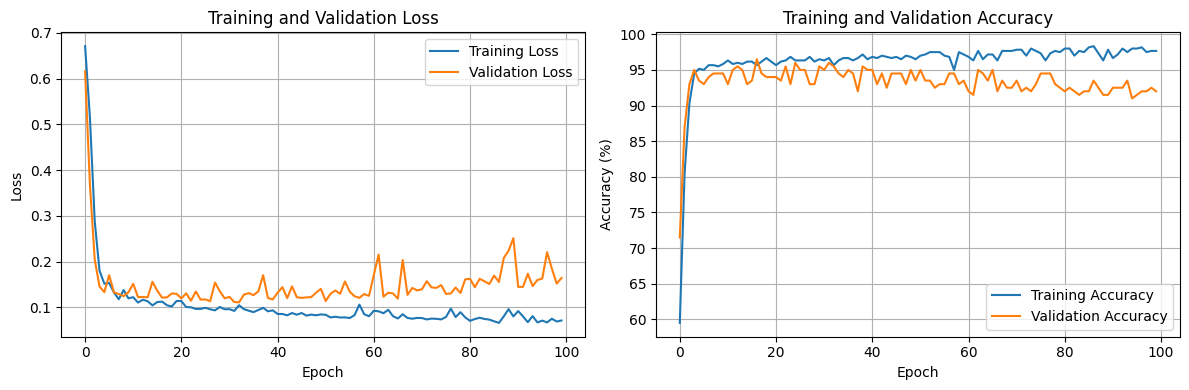


Test Accuracy: 94.00%

Sample Predictions:
Sample 1: Predicted=1 (1.000), Actual=1
Sample 2: Predicted=1 (1.000), Actual=1
Sample 3: Predicted=0 (0.002), Actual=0
Sample 4: Predicted=1 (1.000), Actual=1
Sample 5: Predicted=1 (1.000), Actual=1


In [3]:

    """
    Main function to run the fuzzy neural network
    """
    print("Fuzzy Neural Network Implementation")
    print("=" * 40)

    # Generate sample data
    print("Generating sample data...")
    X, y = generate_sample_data(n_samples=1000, n_features=4, n_classes=2)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.LongTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test)

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize the model
    input_dim = X_train.shape[1]
    num_fuzzy_memberships = 10
    hidden_dim = 20
    output_dim = 1

    print(f"Model Configuration:")
    print(f"  Input dimensions: {input_dim}")
    print(f"  Fuzzy memberships: {num_fuzzy_memberships}")
    print(f"  Hidden layer size: {hidden_dim}")
    print(f"  Output dimensions: {output_dim}")

    model = FuzzyNeuralNetwork(input_dim, num_fuzzy_memberships, hidden_dim, output_dim)

    # Train the model
    print("\nTraining the model...")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, num_epochs=100, learning_rate=0.01
    )

    # Plot results
    plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

    # Test the model
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            predicted = (outputs.squeeze() > 0.5).float()
            test_total += batch_y.size(0)
            test_correct += (predicted == batch_y.float()).sum().item()

    test_accuracy = 100 * test_correct / test_total
    print(f"\nTest Accuracy: {test_accuracy:.2f}%")

    # Show some sample predictions
    print("\nSample Predictions:")
    model.eval()
    with torch.no_grad():
        sample_x = X_test_tensor[:5]
        sample_y = y_test_tensor[:5]
        predictions = model(sample_x)

        for i in range(5):
            pred_prob = predictions[i].item()
            pred_class = int(pred_prob > 0.5)
            actual_class = sample_y[i].item()
            print(f"Sample {i+1}: Predicted={pred_class} ({pred_prob:.3f}), Actual={actual_class}")

